## Best model so far: BGM for meta labels, MLP (400, 200, 100) for supervised classification
## Score: 0.61211

## Tasks
- [x] Rete custom più semplice (200, 100), score: 0.59855
- [x] Testare threshold più alte per il meta labeling, (testata 95%, score: 0.58857) (87% sembra meglio di 80%)
- [ ] Feature engineering
- [x] Provare a usare tutte le colonne per trainare la rete (le performance peggiorano, le feature sono molto rumorose)
- [ ] Migliorare il meta labeling
- [ ] Capire se il limitante è la rete o il labeler
- [ ] Provare reti più profonde
- [x] Batch normalization (stabilizza le performance, nessun impatto significativo)
- [ ] ARI come loss function
- [x] Verificare che le label predette non siano sbilanciate (erano sbilanciate, ma bilanciarle porta a miglioramenti minimi ~0.0006)
- [ ] Silhuette analysis per capire numero di clusters
- [x] Splittare training set per avere un validation
- [x] Controllare che non ci siano ripetizioni nel dataset (non ci sono, se non per i dati int)
- [x] Provare un numero diverso di cluster, 6 o 8 per cominciare. (6 e 8 peggiora, mi sa che sono 7!)
- [ ] Dare più peso ai dati interi può dare risultati migliori (magari si possono riscalare per un fattore costante in modo da rendere più importanti le distanze)
- [ ] Si potrebbe provare a usare self-supervised learning, ma bisogna capire come augmentare i dati per poter usare ad esempio SCAN. Un modo potrebbe essere le reti generative tipo CopulaGAN, CTGAN o TableGAN.
- [x] Auto-encoder per feature distillation (performance peggiori del 12%)
- [x] Auto-encoder inverso (decoder-encoder) per mappare le feature in uno spazio a dimensioni maggiori (non funziona)
- [ ] Starting from our best prediction (~0.61) train a BGMClassifier and then fit-predict the data
- [ ] Combine the previous step with soft voting

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm

import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set Static variables
random_state = 2
#n_folds = 10
n_components = 7
verbose = 500
os.environ['PYTHONHASHSEED'] = str(random_state)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
np.random.seed(random_state)
BEST_CLASS_THRESHOLD = 0.87

NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2000
NUM_WORKERS = 2

In [4]:
# Read training data
data = pd.read_csv("data.csv",index_col = 'id')
sample_submission =pd.read_csv("sample_submission.csv")

In [5]:
int_cols = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13']
data['poisson'] = data[int_cols].sum(axis=1)

<IPython.core.display.Javascript object>


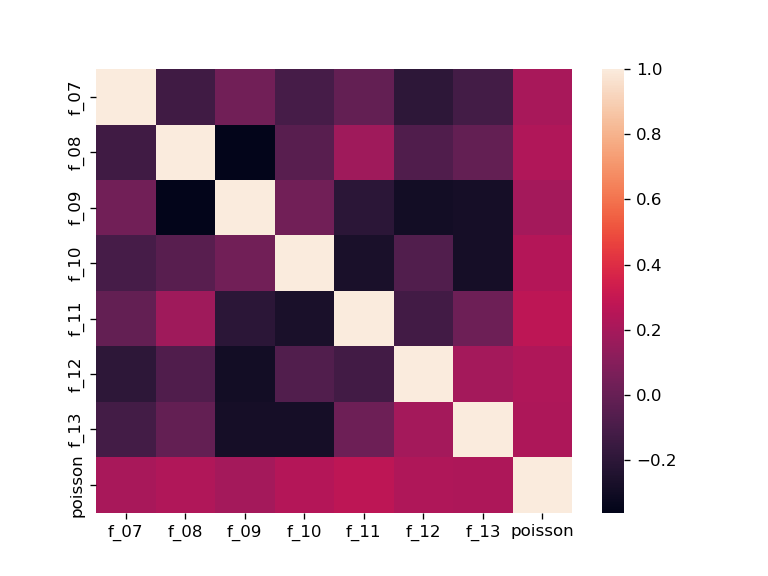

In [30]:
import seaborn as sns

%matplotlib notebook

corr_matrix = data[[*int_cols, 'poisson']].corr()
ax = sns.heatmap(corr_matrix)

In [6]:
# Using PowerTransformer before Scaling to adjust for Outliers
data_scaled = pd.DataFrame(PowerTransformer().fit_transform(data),columns=data.columns)
data_scaled = pd.DataFrame(RobustScaler().fit_transform(data_scaled), columns=data_scaled.columns)
data_scaled = (data_scaled-data_scaled.mean())/data_scaled.std()

#www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/334808
useful_cols  = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28', 'poisson']

# Test Data for predictions later
test_data = data_scaled[useful_cols].copy()

In [7]:
# Fit Bayesian Gaussian Mixture
print('Fitting Bayesian Gaussian Mixture..')
bgm = BayesianGaussianMixture(n_components = n_components,
                         max_iter = 300, n_init = 3, 
                     random_state = random_state,
                 verbose = 1,
             verbose_interval = 100
)

bgm_labels = bgm.fit_predict(data_scaled[useful_cols])
bgm_proba = bgm.predict_proba(data_scaled[useful_cols])

Fitting Bayesian Gaussian Mixture..
Initialization 0
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 1
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 2
  Iteration 100
  Iteration 200
Initialization converged: True


In [8]:
#Using idea from https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting

# Creating Best data based on predicted probability of BGM model

data_scaled['predict']= bgm_labels
data_scaled['predict_proba']=0

for n in range(n_components):
    data_scaled[f'bgm_proba_{n}']= bgm_proba[:,n]
    data_scaled.loc[data_scaled.predict == n,'bgm_proba']=data_scaled[f'bgm_proba_{n}']
    
train_index=np.array([])
for n in range(n_components):
    median=data_scaled[data_scaled.predict==n]['bgm_proba'].median()

    # Experiment with different thresholds
    # Higher thereshold might overfit
    n_inx=data_scaled[(data_scaled.predict==n) & (data_scaled.bgm_proba > BEST_CLASS_THRESHOLD)].index
    
    train_index = np.concatenate((train_index, n_inx))
    print(f'class:{n}',f'median: {round(median,4)}','Training data:'+str(round(len(n_inx)/len(data_scaled[(data_scaled.predict==n)]),2)*100)+'%')
    
    
print(f'\nSize of Training data : {len(train_index)}')

class:0 median: 0.9542 Training data:67.0%
class:1 median: 0.9365 Training data:61.0%
class:2 median: 0.884 Training data:54.0%
class:3 median: 0.9641 Training data:68.0%
class:4 median: 0.9968 Training data:78.0%
class:5 median: 0.9423 Training data:66.0%
class:6 median: 0.9648 Training data:65.0%

Size of Training data : 63229


In [9]:
class LinearLayer(nn.Module):
    def __init__(self, in_neurons, out_neurons):
        super().__init__()
        self.linear = nn.Linear(in_neurons, out_neurons)
        self.do = nn.Dropout(p=0.2)
        self.bn = nn.BatchNorm1d(out_neurons)
        self.act = nn.PReLU()
        
    def forward(self, x):
        return self.bn(self.act(self.do(self.linear(x))))
        

class NetClassifier(nn.Module):
    def __init__(self, in_neurons, hidden_neurons, out_neurons):
        super().__init__()
        
        self.hidden_layers = len(hidden_neurons)
          
        self.net = nn.Sequential(
            LinearLayer(in_neurons, hidden_neurons[0]),
            *[LinearLayer(hn, hidden_neurons[i+1]) for i, hn in enumerate(hidden_neurons[:-1])],
            nn.Linear(hidden_neurons[-1], out_neurons),
        )

    def forward(self, x):
        return self.net(x)
    
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            
            
class MyDataset(Dataset):
    def __init__(self, df):
        super(MyDataset, self).__init__()
        self.labels = df['predict'].values
        self.features = np.float32(df.drop(columns='predict').values)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [22]:
def train_fn(train_loader, val_loader, model, opt, criterion):
    train_losses = []
    loop = tqdm(train_loader, leave=True)
    for x, y in loop:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        print(pred, y)
        raise
        train_loss = criterion(pred, y)
        loop.set_postfix(L_train=train_loss.item())
        train_losses.append(train_loss.item())
        train_loss.backward()
        opt.step()
        opt.zero_grad()
        
    with torch.no_grad():
        model.eval()
        val_losses = []
        for x, y in val_loader:
            y = y.to(DEVICE)
            x = x.to(DEVICE)
            pred = model(x)
            val_loss = criterion(pred, y)
            val_losses.append(val_loss.item())
            loop.set_postfix(L_val=val_loss.item())
        model.train()
        
    return np.mean(train_losses), np.mean(val_losses)


cols = useful_cols.copy()
cols.append('predict')

dataset = MyDataset(data_scaled.loc[train_index][cols])

tot_examples = len(dataset)
split_ratio = 0.8
train_size = int(tot_examples*0.8)
val_size = tot_examples - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

print(n_components)
model = NetClassifier(in_neurons=len(cols)-1, hidden_neurons=[400, 200, 100], out_neurons=n_components).to(DEVICE)
initialize_weights(model)

opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"{epoch}/{NUM_EPOCHS}")
    train_loss, val_loss = train_fn(train_loader, val_loader, model, opt, criterion)
    print(f"t_loss: {train_loss:.4f}\t v_loss: {val_loss:.4f}")

7
1/20


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

tensor([[ 0.9180, -1.1747, -0.9087,  ...,  0.4789,  1.4015, -1.1946],
        [-0.0449, -0.4674,  2.3903,  ..., -2.2647, -0.7602,  2.0536],
        [ 0.3445, -2.2333,  0.5635,  ..., -1.4564,  1.1434, -0.7453],
        ...,
        [ 0.4193,  1.6227, -0.2499,  ...,  0.4395, -0.1623, -1.5091],
        [-1.5173,  1.1109,  0.5612,  ..., -1.8235,  0.6088,  2.3299],
        [-0.1717,  1.7239, -0.5917,  ...,  1.2061,  3.1953, -0.3846]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0, 1, 5,  ..., 4, 6, 3], device='cuda:0')


RuntimeError: No active exception to reraise

In [16]:
model.eval()
model = model.to("cpu")
test = torch.tensor(data_scaled[useful_cols].values, dtype=torch.float32).to("cpu")
output = model(test.to("cpu"))
Predicted = torch.argmax(nn.functional.softmax(output), dim=1).cpu().detach().numpy()

In [20]:
submission = pd.read_csv('sample_submission.csv')
submission['Predicted'] = Predicted
submission.to_csv('submission.csv', index=False)
submission

,Id,Predicted
0,0,5
1,1,7
2,2,5
3,3,3
4,4,7
...,...,...
97995,97995,4
97996,97996,7
97997,97997,1
97998,97998,3
